# 500k Brain Cells
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell as rsc

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 5,5

In [3]:
import rmm
rmm.reinitialize(
    managed_memory=False)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("h5/500000.h5ad")

CPU times: user 528 ms, sys: 5.56 s, total: 6.09 s
Wall time: 17 s


In [6]:
adata.shape

(500000, 27998)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [7]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 2.55 s, sys: 2.16 s, total: 4.7 s
Wall time: 4.72 s


Verify the shape of the resulting sparse matrix:

In [8]:
cudata.shape

(500000, 27998)

And the number of non-zero values in the matrix:

In [9]:
cudata.nnz

1018936313

In [10]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 21.820748567581177


## Preprocessing

In [11]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [12]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 5.95 ms, sys: 0 ns, total: 5.95 ms
Wall time: 5.93 ms


In [13]:
%%time
rsc.pp.calculate_qc(cudata,qc_vars=["MT"])

CPU times: user 1.25 s, sys: 129 ms, total: 1.38 s
Wall time: 1.47 s


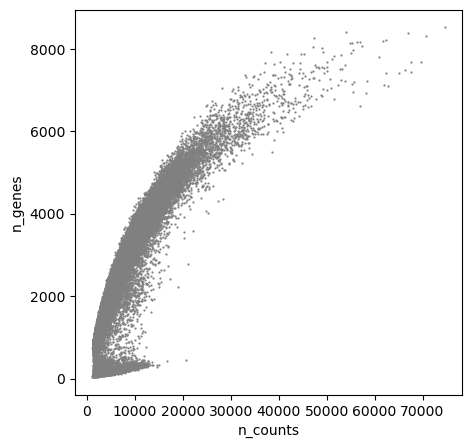

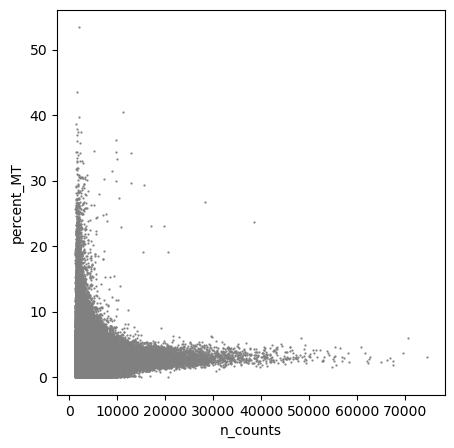

In [14]:
rsc.pl.scatter(cudata,"n_counts","n_genes")
rsc.pl.scatter(cudata,"n_counts","percent_MT")

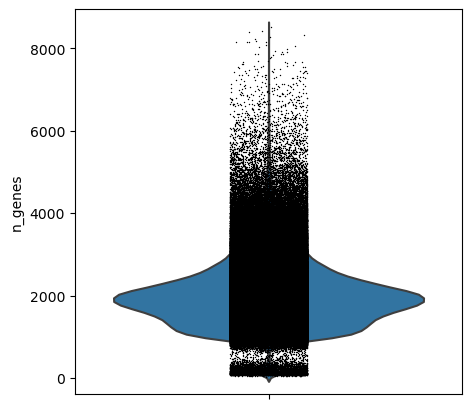

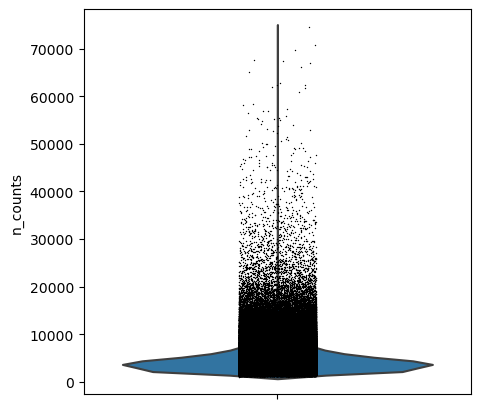

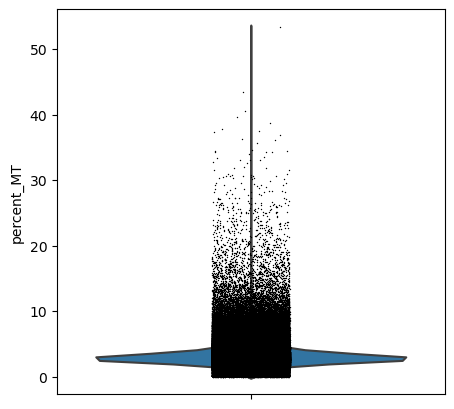

In [15]:
rsc.pl.violin(cudata,key="n_genes")
rsc.pl.violin(cudata,key="n_counts")
rsc.pl.violin(cudata,key="percent_MT")

We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [16]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata = cudata[cudata.obs["n_genes"] > 500]

cudata.shape

CPU times: user 69.4 ms, sys: 38.3 ms, total: 108 ms
Wall time: 109 ms


(492660, 27998)

In [17]:
%%time
cudata = cudata[cudata.obs["percent_MT"] < 20]
cudata.shape

CPU times: user 32.6 ms, sys: 19.3 ms, total: 51.9 ms
Wall time: 50.8 ms


(492376, 27998)

We also filter out genes that are expressed in less than 3 cells.

In [18]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 6139 genes based on n_cells
CPU times: user 430 ms, sys: 55.9 ms, total: 486 ms
Wall time: 719 ms


In [19]:
cudata.layers["counts"] = cudata.X.copy()

In [20]:
cudata.shape

(492376, 21859)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [21]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 0 ns, sys: 551 µs, total: 551 µs
Wall time: 3.26 ms


Next, we log transform the count matrix.

In [22]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 26.8 ms, sys: 10.9 ms, total: 37.8 ms
Wall time: 39.2 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [23]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",layer = "counts")

CPU times: user 1.26 s, sys: 4.34 s, total: 5.6 s
Wall time: 1.55 s


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [24]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 1.68 s, sys: 979 ms, total: 2.66 s
Wall time: 2.66 s


Now we restrict our cunndata object to the highly variable genes.

In [25]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 540 ms, sys: 87.6 ms, total: 627 ms
Wall time: 627 ms


In [26]:
cudata.shape

(492376, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [27]:
%%time
rsc.pp.regress_out(cudata,keys=["n_counts", "percent_MT"])

CPU times: user 2.49 s, sys: 1.96 s, total: 4.45 s
Wall time: 5.09 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [28]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 254 ms, sys: 486 ms, total: 740 ms
Wall time: 1.52 s


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `cunndata_funcs` that uses cuMLs PCA to run this.

In [29]:
%%time
rsc.pp.pca(cudata, n_comps = 100)

CPU times: user 2.6 s, sys: 123 ms, total: 2.72 s
Wall time: 3.15 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

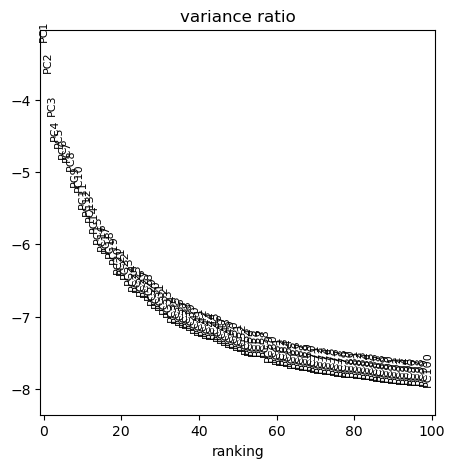

In [30]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=100)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [31]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 1.73 s, sys: 1.24 s, total: 2.98 s
Wall time: 2.98 s


In [32]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 25.790220499038696


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [33]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=60, method='rapids')

CPU times: user 17.3 s, sys: 1.93 s, total: 19.3 s
Wall time: 15.7 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [34]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 6.64 s, sys: 45.5 ms, total: 6.68 s
Wall time: 6.68 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [35]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 1.05 s, sys: 2.62 s, total: 3.66 s
Wall time: 4.02 s


In [36]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 522 ms, sys: 113 ms, total: 635 ms
Wall time: 635 ms


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


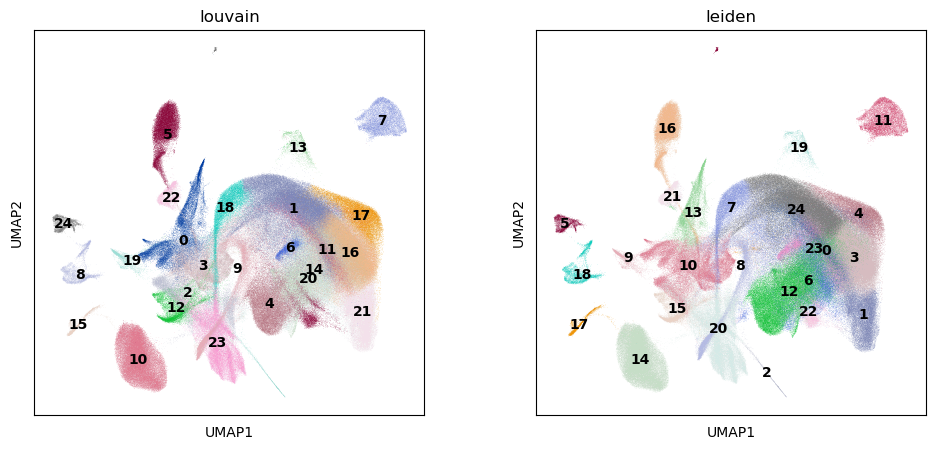

CPU times: user 2.88 s, sys: 172 ms, total: 3.05 s
Wall time: 2.89 s


In [37]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

We also caluclate the embedding density in the UMAP using cuML

## TSNE

In [38]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

[W] [10:59:21.529731] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 7.44 s, sys: 5.43 s, total: 12.9 s
Wall time: 12.9 s


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


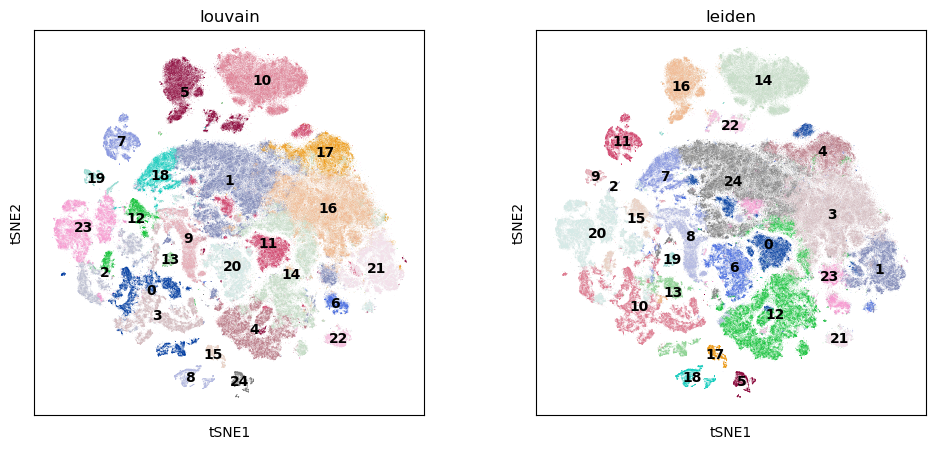

In [39]:
sc.pl.tsne(adata,color=["louvain","leiden"], legend_loc='on data')

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Leidencluster.

In [40]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="leiden",layer="counts", use_raw=False)

[W] [11:00:25.416038] L-BFGS: max iterations reached
[W] [11:00:25.416471] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 45 s, sys: 2.85 s, total: 47.9 s
Wall time: 48.3 s


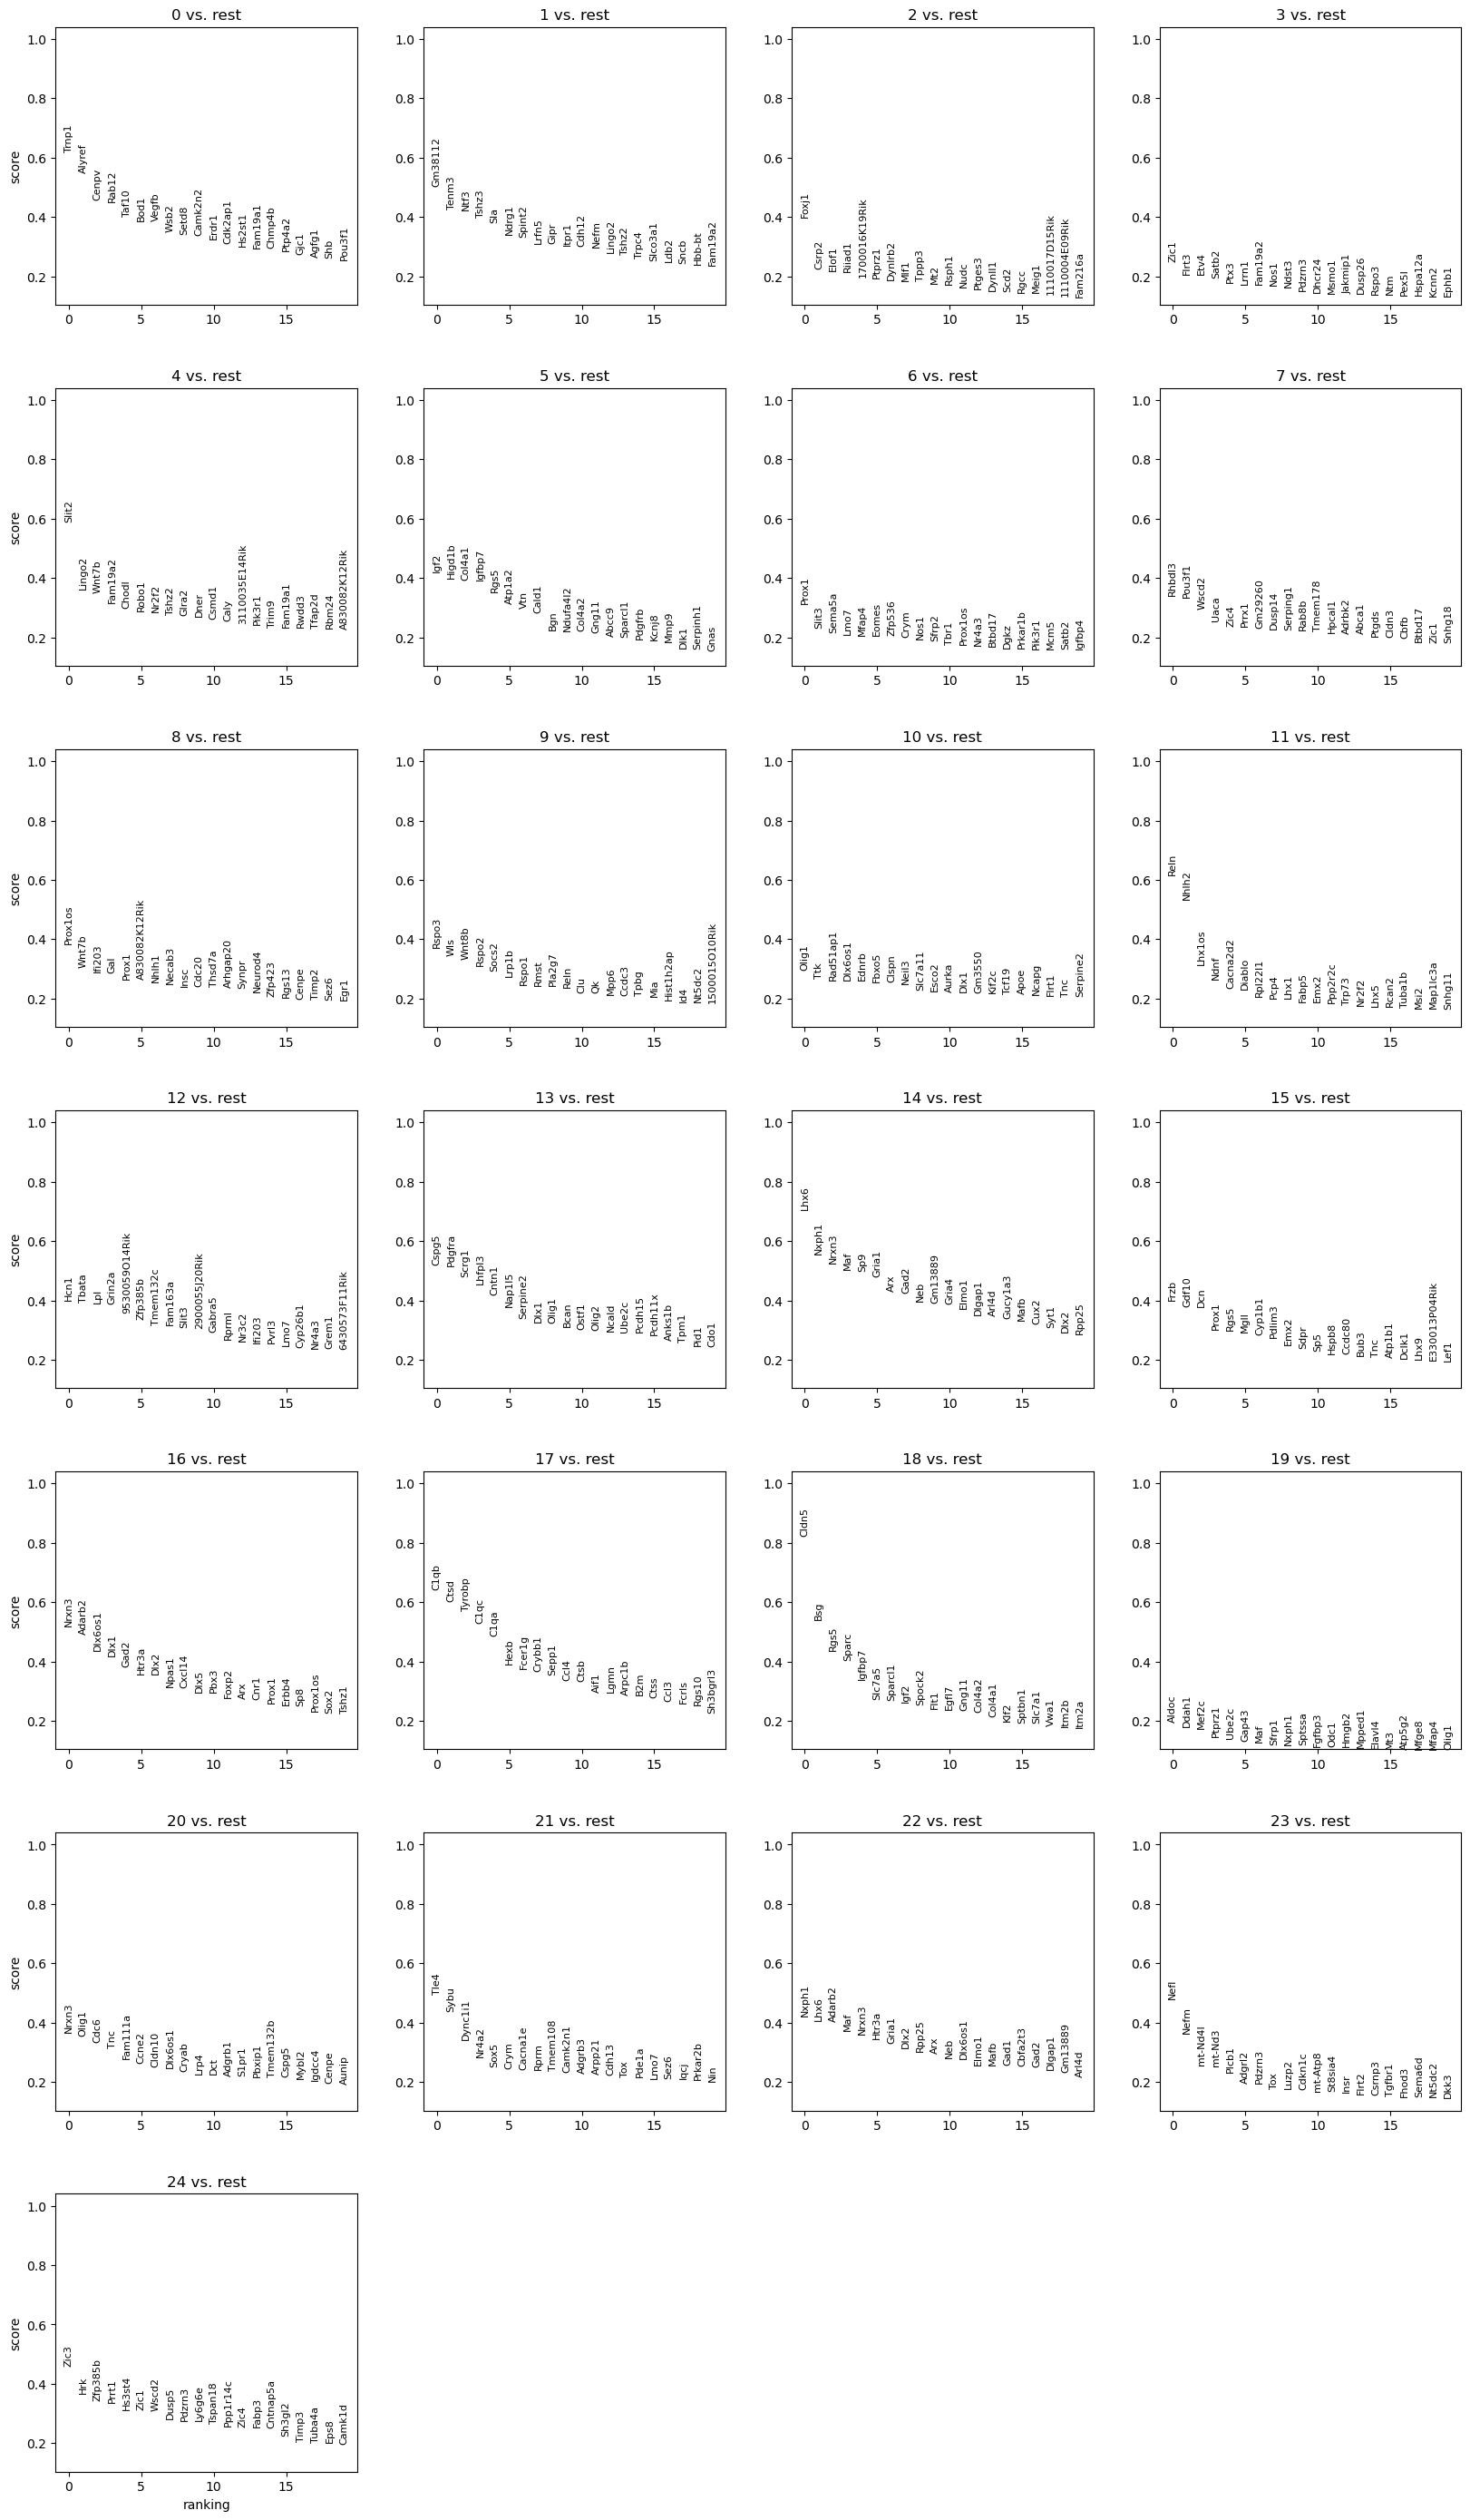

CPU times: user 2.02 s, sys: 186 ms, total: 2.21 s
Wall time: 2.03 s


In [41]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Diffusion Maps

In [42]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:] 

CPU times: user 1.29 s, sys: 4.78 s, total: 6.07 s
Wall time: 622 ms


/home/sedi10/conda/envs/rapids-23.02/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


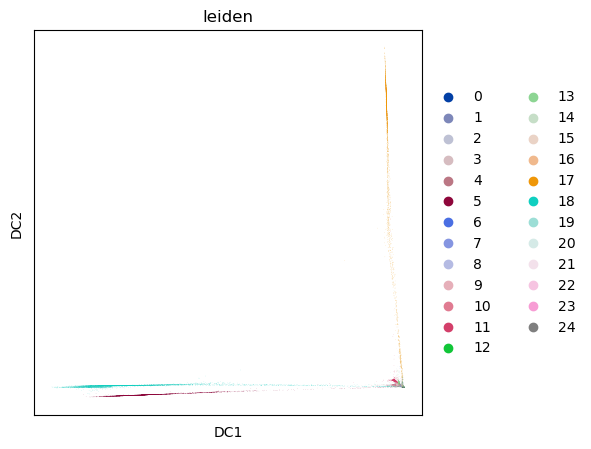

In [43]:
sc.pl.diffmap(adata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [44]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 124.03932690620422
